## REFERENCES

## 0. Imports & functions

In [2]:
#imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import random
% matplotlib inline

import sklearn
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
import sklearn.cross_validation as cv
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings('ignore')

/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
file_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/pre-processing/dfFinal.csv'
df=pd.read_csv(file_path)
df.drop(columns='Unnamed: 0',inplace=True)
df.drop(columns=['EVENT_ID','INFODT'],inplace=True)
#df.set_index(keys=['PATNO'],inplace=True)
df.head()
## CURRCOND data

,PATNO,INFODT_date,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,NP2SALV,...,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,VISIT_ID,visitsdiff_days,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
0,3001,2011-02-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,2,7,1,0,2707,306,0,0
1,3001,2012-03-01,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,2,7,2,394,2313,700,0,0
2,3001,2013-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,2,7,3,426,1887,1126,0,0
3,3001,2014-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,2,7,4,335,1552,1461,0,0
4,3001,2015-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,2,7,5,365,1187,1826,0,0


Time-series prediction (input timestep=3)

In [142]:
def patients_selection(df, threshold=6):
    '''return a dataframe containing only the patients with number of visits > threshold'''
    if 'PATNO' in df.columns: 
        visits_number_by_pat=df.groupby('PATNO').size().sort_values(ascending=False)
        mask_sel=visits_number_by_pat>=threshold
        patients_sel=list(mask_sel[mask_sel.values==True].index)
        df=df.loc[df['PATNO'].isin(patients_sel),:]
        df=df.sort_values('PATNO')
        return (patients_sel, df)
    else:
        return 0

df_th2=patients_selection(df,threshold=2)[1]
print(df_th2.shape)
df_th2['num_visits'].value_counts()

(4784, 379)
(4113, 376)


6    852
7    714
2    586
3    564
5    525
4    512
8    360
Name: num_visits, dtype: int64

### padding for patients with visits <4

In [143]:
rowstoAdd=df_th2[df_th2['num_visits']==2].groupby('PATNO').median()
rowstoAdd['VISIT_ID']=3
rowstoAdd['visitsdiff_days']=3*61
rowstoAdd['lastDate_diff_days']=rowstoAdd['lastDate_diff_days']-rowstoAdd['visitsdiff_days']
rowstoAdd['PDDXDT_diff_days']=rowstoAdd['PDDXDT_diff_days'].where(rowstoAdd['PDDXDT_diff_days']==0,
                                                                 rowstoAdd['PDDXDT_diff_days']+rowstoAdd['visitsdiff_days'])
maskMED=rowstoAdd['PDMEDT_diff_days']!=0
rowstoAdd.loc[maskMED,'PDMEDT_diff_days']=rowstoAdd.loc[maskMED,'PDMEDT_diff_days']+rowstoAdd.loc[maskMED,'visitsdiff_days']
maskSURG=rowstoAdd['PDSURGDT_diff_days']!=0
rowstoAdd.loc[maskSURG,'PDSURGDT_diff_days']=rowstoAdd.loc[maskSURG,'PDSURGDT_diff_days']+rowstoAdd.loc[maskSURG,'visitsdiff_days']

rowstoAdd2=df_th2[df_th2['num_visits']==2].groupby('PATNO').median()
rowstoAdd2['VISIT_ID']=4
rowstoAdd2['visitsdiff_days']=3*61
rowstoAdd2['lastDate_diff_days']=rowstoAdd2['lastDate_diff_days']-rowstoAdd2['visitsdiff_days']
rowstoAdd2['PDDXDT_diff_days']=rowstoAdd2['PDDXDT_diff_days'].where(rowstoAdd2['PDDXDT_diff_days']==0,
                                                                 rowstoAdd2['PDDXDT_diff_days']+rowstoAdd2['visitsdiff_days'])

rowstoAdd2.loc[maskMED,'PDMEDT_diff_days']=rowstoAdd2.loc[maskMED,'PDMEDT_diff_days']+rowstoAdd2.loc[maskMED,'visitsdiff_days']
rowstoAdd2.loc[maskSURG,'PDSURGDT_diff_days']=rowstoAdd2.loc[maskSURG,'PDSURGDT_diff_days']+rowstoAdd2.loc[maskSURG,'visitsdiff_days']


rows3toAdd=df_th2[df_th2['num_visits']==3].groupby('PATNO').median()
rows3toAdd['VISIT_ID']=4
rows3toAdd['visitsdiff_days']=3*61
rows3toAdd['lastDate_diff_days']=rows3toAdd['lastDate_diff_days']-rows3toAdd['visitsdiff_days']
rows3toAdd['PDDXDT_diff_days']=rows3toAdd['PDDXDT_diff_days'].where(rows3toAdd['PDDXDT_diff_days']==0,
                                                                 rows3toAdd['PDDXDT_diff_days']+rows3toAdd['visitsdiff_days'])
mask3MED=rows3toAdd['PDMEDT_diff_days']!=0
rows3toAdd.loc[mask3MED,'PDMEDT_diff_days']=rows3toAdd.loc[mask3MED,'PDMEDT_diff_days']+rows3toAdd.loc[mask3MED,'visitsdiff_days']
mask3SURG=rows3toAdd['PDSURGDT_diff_days']!=0
rows3toAdd.loc[mask3SURG,'PDSURGDT_diff_days']=rows3toAdd.loc[mask3SURG,'PDSURGDT_diff_days']+rows3toAdd.loc[mask3SURG,'visitsdiff_days']

rowspadding=pd.concat([rowstoAdd,rowstoAdd2,rows3toAdd])
rowspadding['num_visits']=4
rowspadding.reset_index(inplace=True)
print(rowspadding.shape)
dfpad_th4=df_th2.drop(columns='INFODT_date')
print(dfpad_th4.shape)
dfpad_th4=pd.concat([dfpad_th4,rowspadding])
print(dfpad_th4.shape)
dfpad_th4['num_visits'].replace(2,4,inplace=True)
dfpad_th4['num_visits'].replace(3,4,inplace=True)
dfpad_th4.reset_index(drop=True,inplace=True)
dfpad_th4.head()
print((len(rowstoAdd),len(rows3toAdd)))

(774, 375)
(4113, 375)
(4887, 375)
(293, 188)


In [147]:
#dfpad_th4['NHY']=dfpad_th4['NHY'].apply(lambda x: round(x,0))
dfpad_th4.sort_values(['PATNO','VISIT_ID'],inplace=True)
print(dfpad_th4.shape)

datatoDrop=dfpad_th4[dfpad_th4['num_visits']==dfpad_th4['VISIT_ID']]
print(datatoDrop.shape)
#data_TS=dfpad_th4.drop(index=list(datatoDrop.index),columns=['MSEADLG','visits_thresold'])
data_TS.set_index(keys=['PATNO'],inplace=True)
print(data_TS.shape)

#dd=data_TS['NHY']

targettoDrop=dfpad_th4[dfpad_th4['VISIT_ID']==1]
print(targettoDrop.shape)
target_TS=dfpad_th4.drop(index=list(targettoDrop.index))
target_TS.set_index(keys=['PATNO'],inplace=True)
assert len(target_TS)==len(data_TS)
assert set(data_TS.index)==set(target_TS.index)

#target_TS=target_TS['NHY']

print(target_TS.shape)
list(set(target_TS.values))

(4887, 376)
(1003, 376)
(3884, 373)
(1003, 376)
(3884,)


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

`from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import numpy as np
X, y1 = make_classification(n_samples=10, n_features=100, n_informative=30, n_classes=3, random_state=1)
y2 = shuffle(y1, random_state=1)
y3 = shuffle(y1, random_state=2)
Y = np.vstack((y1, y2, y3)).T
n_samples, n_features = X.shape # 10,100
n_outputs = Y.shape[1] # 3
n_classes = 3
forest = RandomForestClassifier(n_estimators=100, random_state=1)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
multi_target_forest.fit(X, Y).predict(X)
array([[2, 2, 0],
       [1, 2, 1],
       [2, 1, 0],
       [0, 0, 2],
       [0, 2, 1],
       [0, 0, 2],
       [1, 1, 0],
       [1, 1, 1],
       [0, 0, 2],
       [2, 0, 0]])`

### Training ML models (Logistic Regression, RandomForest, XGBoost)

#### custom train/test split for time-series data

In [148]:
print(round(0.2*len(set(data_TS.index)),0))
np.random.seed(123)
pat_testset=np.random.choice(list(set(data_TS.index)),201,replace=False)
X_test=data_TS.loc[pat_testset,:]
X_test.head(50)
print(X_test.shape)
X_train=data_TS.drop(index=pat_testset)
print(X_train.shape)
y_test=target_TS[pat_testset]
print(y_test.shape)
assert set(y_test.index)==set(X_test.index)
y_train=target_TS.drop(index=pat_testset)
print(y_train.shape)
assert set(y_train.index)==set(X_train.index)

201.0
(787, 373)
(3097, 373)
(787,)
(3097,)


#### DummyClassifier

In [149]:
from sklearn.dummy import DummyClassifier
dummy=DummyClassifier()
dummy.fit(X_train, y_train)

#### Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg_TS = LogisticRegression(multi_class='multinomial',solver='newton-cg',random_state=0)
logreg_TS.fit(X_train, y_train)

#### Random Forest
rfc_TS = RandomForestClassifier(n_estimators=100, random_state=1,n_jobs=-1)
rfc_TS.fit(X_train, y_train)

#### XGBoost
from xgboost import XGBClassifier
xgb_TS = XGBClassifier(n_jobs=-1,seed=0)
xgb_TS.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

In [150]:
print("Train-Score-dummy: %.4f, Test-Accuracy-dummy: %.4f" % (dummy.score(X_train, y_train), dummy.score(X_test, y_test)))

Train-Score-dummy: 0.3807, Test-Accuracy-dummy: 0.4193


In [151]:
print("Train-Score-logreg: %.4f, Test-Accuracy-logreg: %.4f" % (logreg_TS.score(X_train, y_train), logreg_TS.score(X_test, y_test)))
print("Train-Score-rfc: %.4f, Test-Accuracy-rfc: %.4f" % (rfc_TS.score(X_train, y_train), rfc_TS.score(X_test, y_test)))
print("Train-Score-xgb: %.2f, Test-Accuracy-xgb: %.2f" % (xgb_TS.score(X_train, y_train), 
                                                          xgb_TS.score(X_test, y_test)))

Train-Score-logreg: 0.8802, Test-Accuracy-logreg: 0.7789
Train-Score-rfc: 1.0000, Test-Accuracy-rfc: 0.8221
Train-Score-xgb: 0.89, Test-Accuracy-xgb: 0.82


### PLotting the results. 

In [152]:
y_pred_logreg=logreg_TS.predict(X_test)
predictions_logreg=pd.Series(y_pred_logreg,index=y_test.index)

y_test_pred_logreg=pd.concat([y_test,predictions_logreg],axis=1)
y_test_pred_logreg.rename(columns={'NHY':'trueLabel',0:'prediction_logreg'},inplace=True)

VISIT_ID=[2]
for i in range(1,len(y_test_pred_logreg)):
    if (y_test_pred_logreg.index[i]==y_test_pred_logreg.index[i-1]):
        visit=VISIT_ID[len(VISIT_ID)-1]+1
    else:
        visit=2
    VISIT_ID.append(visit)
print(len(VISIT_ID))
y_test_pred_logreg['VISIT_ID_future']=VISIT_ID

y_pred_rfc=pd.Series(rfc_TS.predict(X_test),index=y_test.index)
y_pred_rfc.name='prediction_rfc'
y_pred_xgb=pd.Series(xgb_TS.predict(X_test),index=y_test.index)
y_pred_xgb.name='prediction_xgb'

test_all=pd.concat([X_test,y_test_pred_logreg, y_pred_rfc,y_pred_xgb],axis=1)
print(len(test_all))
results_toplot=test_all[['num_visits','VISIT_ID','NHY','VISIT_ID_future','trueLabel',
                         'prediction_logreg','prediction_rfc','prediction_xgb']]
results_toplot.reset_index(inplace=True)
results_toplot.head()

787
787


,PATNO,num_visits,VISIT_ID,NHY,VISIT_ID_future,trueLabel,prediction_logreg,prediction_rfc,prediction_xgb
0,51659,4,1,3.0,2,3.0,2.0,2.0,2.0
1,51659,4,2,3.0,3,3.0,2.0,2.0,2.0
2,51659,4,3,3.0,4,3.0,2.0,2.0,3.0
3,50009,4,1,0.0,2,0.0,0.0,0.0,0.0
4,50009,4,2,0.0,3,0.0,0.0,0.0,0.0


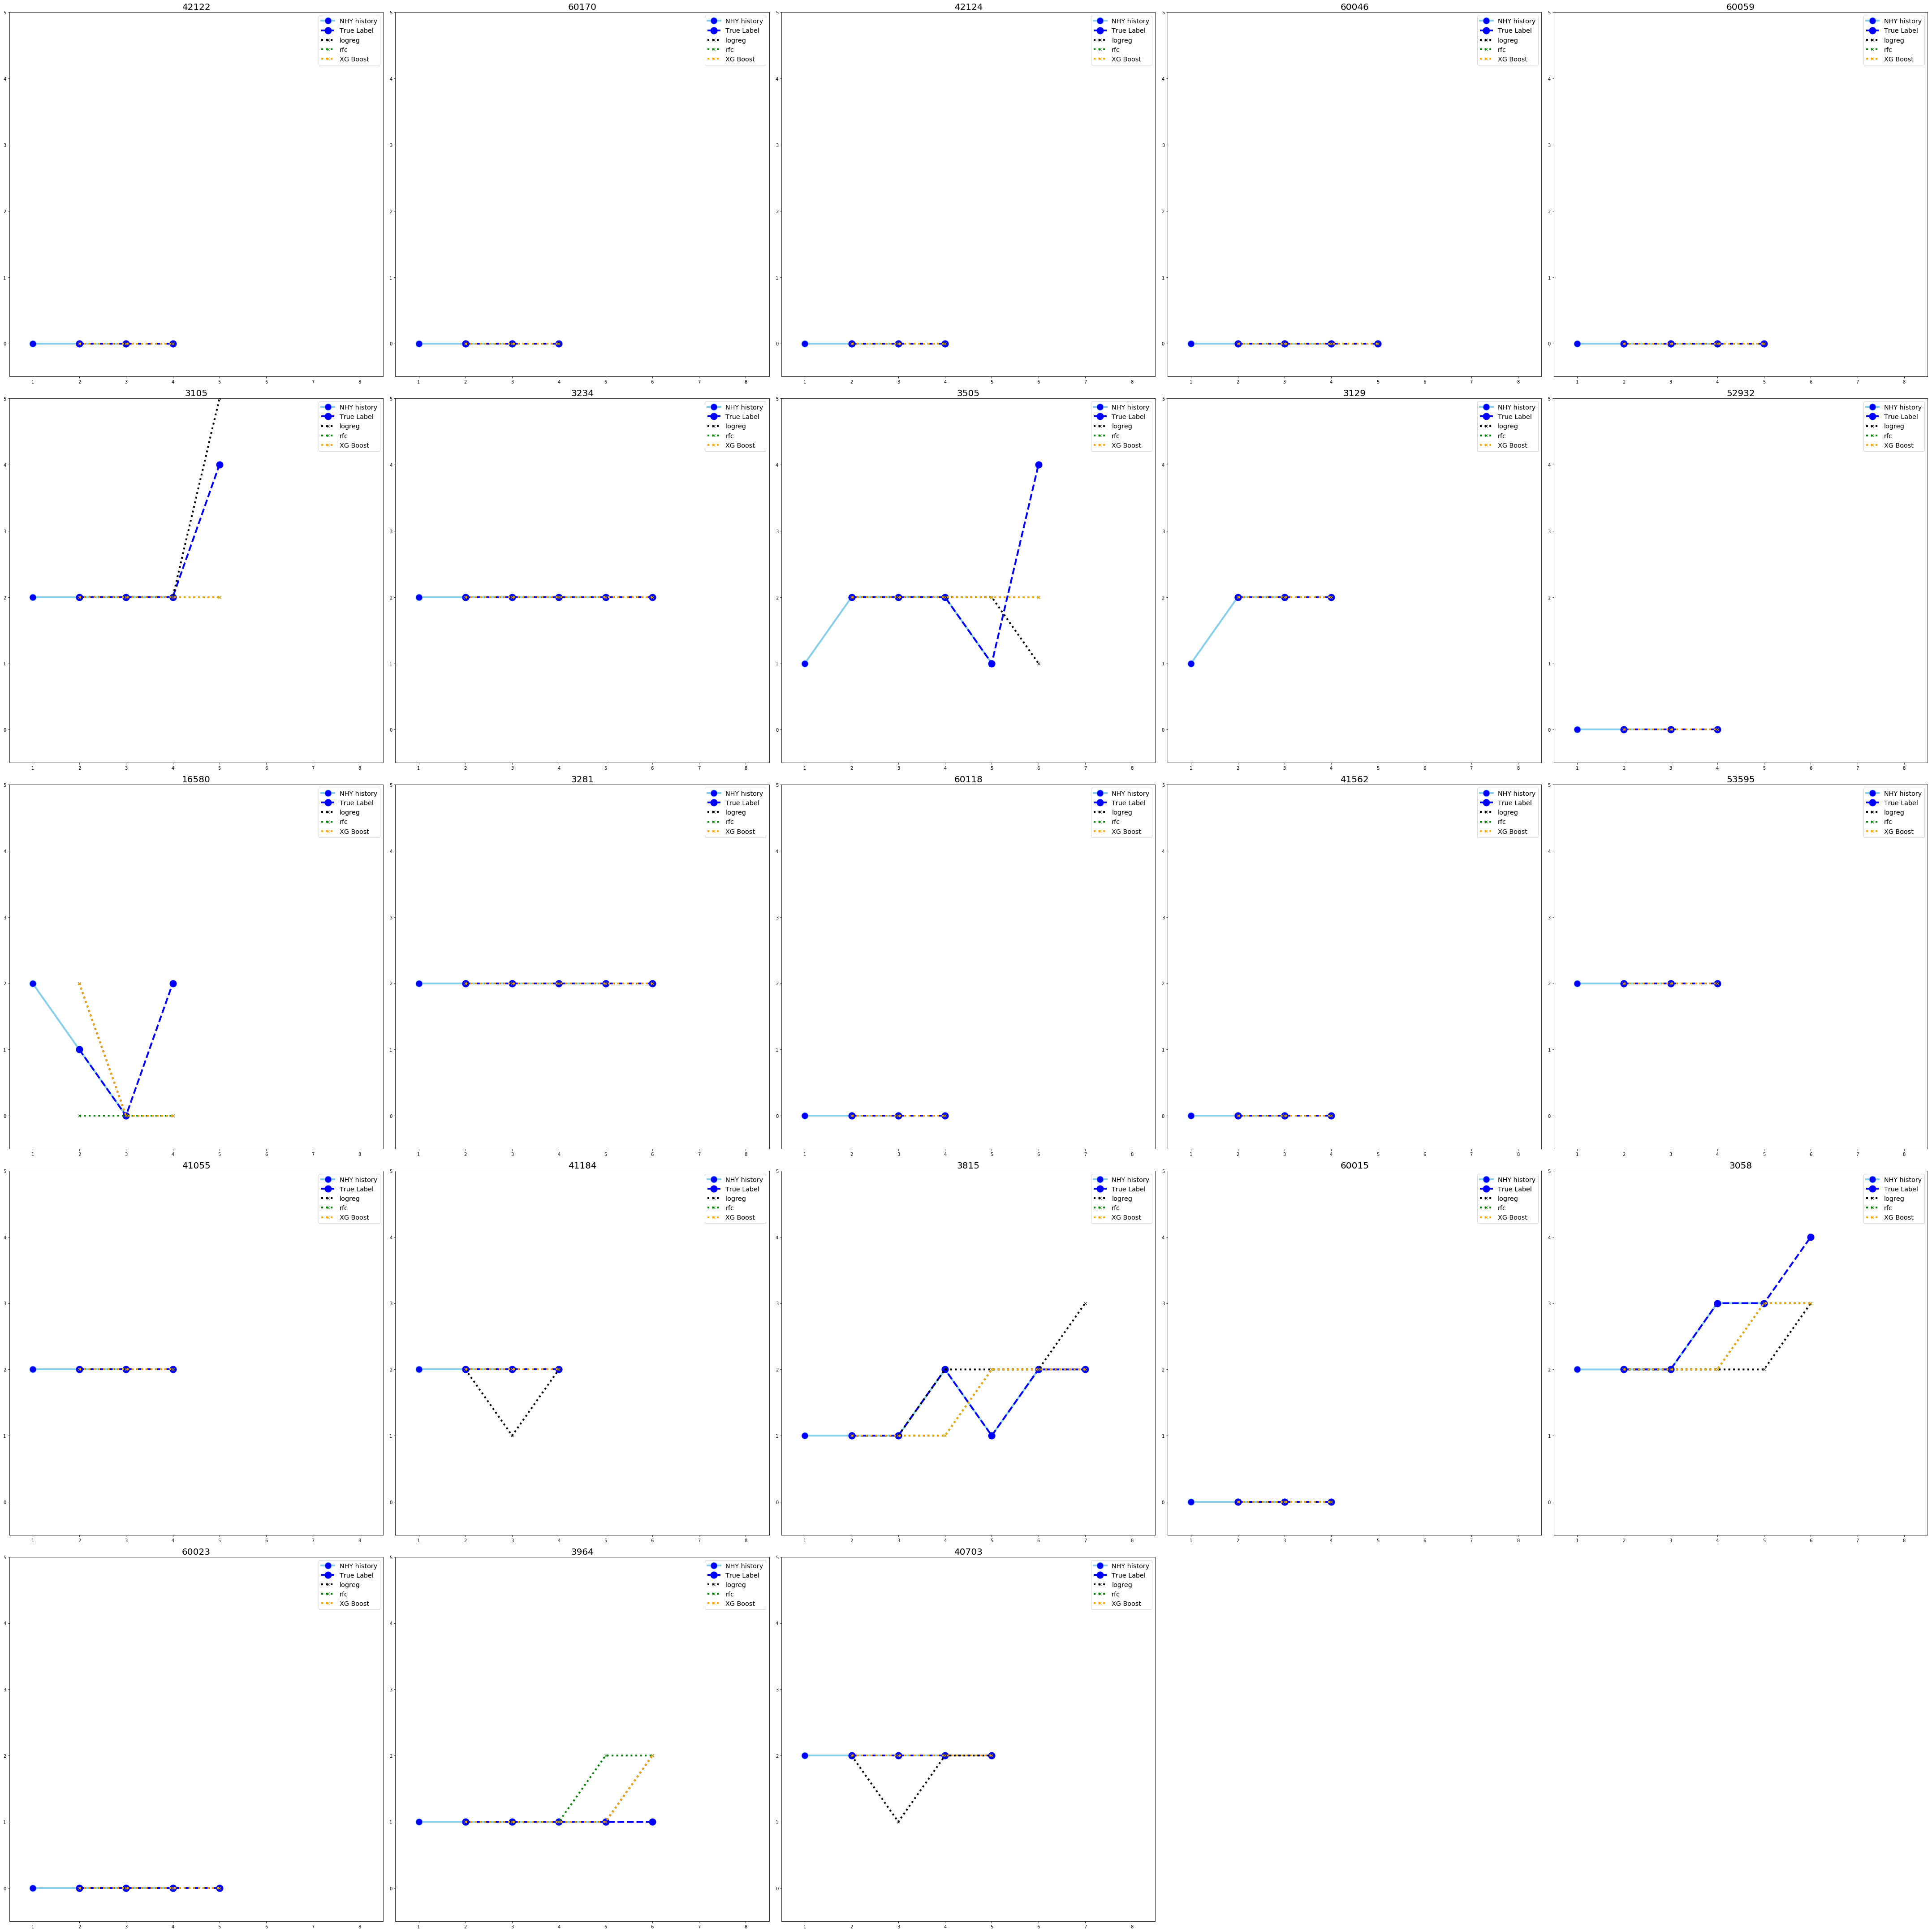

In [153]:
def patients_sampling(df,sample_size=25,seed=123):
    np.random.seed(seed)
    sample=list(np.random.randint(0,len(set(df['PATNO'])),sample_size+1))
    patients_sample=pd.Series(list(set(df['PATNO'])))[sample]
    patients_sample=list(patients_sample.values)
    sub_df=df.loc[df['PATNO'].isin(patients_sample),:]
    return sub_df
df_toPlot=patients_sampling(results_toplot)

fig = plt.figure(figsize=(60,60))
num_pat=len(set(df_toPlot['PATNO']))
for pat,num in zip(list(set(df_toPlot['PATNO'])),range(1,num_pat+1)):
    df0=df_toPlot[df_toPlot['PATNO']==pat]
    ax = fig.add_subplot(5,5,num)
    ax.plot(df0['VISIT_ID'], df0['NHY'],marker='o', markerfacecolor='blue', markersize=15, 
            color='skyblue', linewidth=4,label='NHY history')
    ax.plot(df0['VISIT_ID_future'], df0['trueLabel'],marker='o',markersize=15,
            color='blue',linestyle='dashed',linewidth=4,label='True Label')
    ax.plot(df0['VISIT_ID_future'], df0['prediction_logreg'], marker='x', 
            color='black', linewidth=4, linestyle='dotted', label='logreg')
    ax.plot(df0['VISIT_ID_future'], df0['prediction_rfc'], marker='x', 
            color='green', linewidth=4, linestyle='dotted', label='rfc')
    ax.plot(df0['VISIT_ID_future'], df0['prediction_xgb'], marker='x', 
            color='orange', linewidth=4, linestyle='dotted', label='XG Boost')
    ax.set_xlim([0.5, 8.5])
    ax.set_ylim([-0.5, 5])
    ax.set_title(pat,fontdict={'fontsize':20})
    ax.legend(fontsize='x-large')
plt.tight_layout()
#fig.figure.suptitle('true labels vs predictions')
plt.savefig('/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/ML_predictions/predictions_graph_123.png')
plt.show()

### Try ensemble learning: see example below:

`from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
#eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[2,1,2])

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
...     scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
...     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
Accuracy: 0.90 (+/- 0.05) [Logistic Regression]
Accuracy: 0.93 (+/- 0.05) [Random Forest]
Accuracy: 0.91 (+/- 0.04) [naive Bayes]
Accuracy: 0.95 (+/- 0.05) [Ensemble]`

### Features importance: to compare with simple classification problem

In [155]:
feature_importances = pd.DataFrame(rfc_TS.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
ImportantFeatures_TS=feature_importances[feature_importances.values>=0.01]
print(ImportantFeatures.values.sum())
ImportantFeatures_TS
#feature_importances

0.4054402725052078


,importance
NHY,0.078977
PDDXDT_diff_days,0.052987
PRIMDIAG,0.028993
DFBRADYA,0.021632
NP3BRADY,0.020935
DOMSIDE,0.019052
DFRIGIDP,0.017468
NP3FACXP,0.015325
DXTREMOR,0.013277
DFBRADYP,0.012503


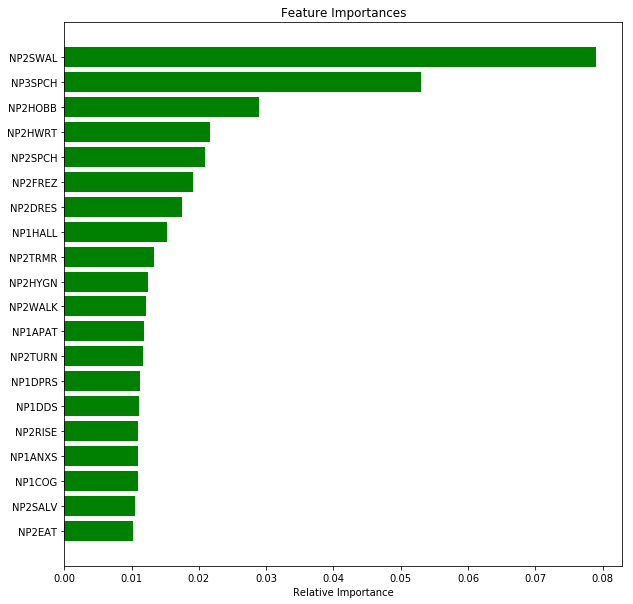

In [159]:
plot_importantFeatures(rfc_TS,X_train,color='green')